In [1]:
# Generic Dependencies
import numpy as np
from numpy import arange
import pandas as pd
from pandas import set_option
# from pandas.tools.plotting import scatter_matrix
import os

# Plotting Libraries
from matplotlib import pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, LassoCV, Ridge,RidgeCV
from sklearn.model_selection import cross_validate

# library for saving models
from sklearn.externals import joblib

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

#XGBoost libraries
import xgboost as xgb

# explain xgboost preiction and model
import shap


# import generateXdata.py to prepare the data
# from generateXdata import generateX
from generateXdata import generateX

#Import Custom ml models
from Cls_ml_models import ml_models_tuned


In [2]:
def generateX_sample(ohe = True, target = "BTU"):    

    dataFilePath = "dataforfinalproject"
    filename = "predict_sample.csv"
    cols_file = "Final_Columns_withCat.csv"

    # read dataset wih all years combined data
    df_recs = pd.read_csv(os.path.join(dataFilePath, filename), low_memory= False)


    # read the columns from Columns csv
    df_cols = pd.read_csv(os.path.join(dataFilePath, cols_file))
#     df_cols.columns

    # Whittle down the dataset to contain only Features required for modeling - X 
    modelDF = df_recs[df_cols[df_cols.FEATURES_MODEL == "Y"].COLUMN_NAME]
    print(f" X Features shape : {modelDF.shape}")

    y_label = df_recs['TOTALBTU']
    print(f"y label shape : {y_label.shape}")

    ### Prepare Data

    # describe the dataframe that will be used for model
    descrDF = modelDF[df_cols[(df_cols.FEATURES_MODEL == "Y")].COLUMN_NAME].describe()
    
    # transpose to make it easier to obtain columns with values of 99 and <0
    descrDF = descrDF.transpose().reset_index()

    # obtain column names with values 99. 99 indicates missing or unavailable info. this needs to be replaced with MOde
    cols99_2 = descrDF[(descrDF['max'] == 99.0) | (descrDF['min'] < 0) ]['index'].tolist()
    print(f"cols with values as 99 and -2: {cols99_2} \n")

   
    # For all categorical columns, that have 99 and -2 , replace with Columns Mode value#
    # step 1 - Fill na for thse values of 99 and -2
    # Step 2: Fillna with mode

    # step1 
    modelCopy = modelDF.copy()
    modelDF[cols99_2] = modelDF[cols99_2].applymap(lambda r : None if r in [99,-2] else r)


    #step2 :
    modelDF[cols99_2] = modelDF[cols99_2].fillna(modelDF.min().iloc[0])

    # just for Col EDishw, the values are in -ve  (-9, -8 )so replace it in a separate line
    modelDF['ESDISHW'] = modelDF['ESDISHW'].apply(lambda r : 0 if (r < 0) else r)

    # check if NAN exists
    print(f"Duplicate Count : {modelDF.isnull().values.sum()}")


    modelDF[df_cols[(df_cols.FEATURES_MODEL == "Y") & (df_cols.COLUMN_TYPE == "Categorical")].COLUMN_NAME].describe()

    if(target == "BTU"):
        # Drop Price / Cost related Columns as it is only Consumption we are interested in 
        cost_cols = df_cols[(df_cols['COLUMN_NAME'].str.find("DOL") != -1) & (df_cols.FEATURES_MODEL == "Y")].COLUMN_NAME.tolist()
        modelDF.drop(cost_cols, axis = 1, inplace = True)
        # Drop All BTU related cols too
        btu_cols = df_cols[(df_cols['COLUMN_NAME'].str.find("BTU") != -1) & (df_cols.FEATURES_MODEL == "Y")].COLUMN_NAME.tolist()
        modelDF.drop(btu_cols, axis = 1, inplace = True)
        
        # and drop TOTAL BTU from X set
#         X = modelDF.drop(['TOTALBTU'], axis = 1)
    else:
        # Drop Price / Cost related Columns as it is only Consumption we are interested in 
        cost_cols = df_cols[(df_cols['COLUMN_NAME'].str.find("DOL") != -1) & (df_cols.FEATURES_MODEL == "Y")].COLUMN_NAME.tolist()
        modelDF.drop(cost_cols, axis = 1, inplace = True)
        
        # Also drop the Total BTU cols 
        btu_cols = df_cols[(df_cols['COLUMN_NAME'].str.find("TOTALBTU") != -1) & (df_cols.FEATURES_MODEL == "Y")].COLUMN_NAME.tolist()
        modelDF.drop(btu_cols, axis = 1, inplace = True)


            # and drop TOTAL BTU from X set
#         X = modelDF.drop(['TOTALDOLLAR'], axis = 1)
        
    X = modelDF
    print(f"shape of X is {X.shape}")

    if(ohe):
        ### Apply dict vectorizer 
        # convert the X array into a dict
        X_dict = X.to_dict(orient = "records")
       

        # instantiate a Dictvectorizer object for X
        dv_X = DictVectorizer(sparse=False)   # sparse = False makes the output is not a sparse matrix

        # apply dv_X on X_dict
        X_encoded = dv_X.fit_transform(X_dict)
        
        vocab = dv_X.get_feature_names()
        # return X_encoded and its vocab
        return (X_encoded, vocab)
    else:
        return (X, X.columns)


In [3]:
# gobal variables
dataFilePath = "dataforfinalproject"
filename = "predict_sample.csv"
cols_file = "Final_Columns_withCat.csv"

 


In [4]:
X, vocab = generateX_sample(ohe = True, target = "DOLLAR")

 X Features shape : (5, 87)
y label shape : (5,)
cols with values as 99 and -2: ['FUELPOOL', 'AGERFRI2', 'AGEFRZR', 'DWASHUSE', 'AGECENAC', 'NUMBERAC', 'WWACAGE', 'USEWWAC', 'ESDISHW', 'WOODAMT'] 

Duplicate Count : 0
shape of X is (5, 79)


In [5]:
y = pd.read_csv(os.path.join(dataFilePath,filename), low_memory = False)['TOTALDOLLAR']

In [6]:
# load the model into a list
model_name = ["Classic Lasso","Elasticnet", "LassoCV", "LR","RF", "RidgeCV","XGB"]
models = [joblib.load(os.path.join("final_models",file)) for file in os.listdir("final_models") if file.endswith("sav")]

In [7]:
models

[Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
     max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
     positive=False, precompute='auto', random_state=None,
     selection='cyclic', tol=0.0001, verbose=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,

In [8]:
X.shape

(5, 79)

In [9]:
results_data = pd.DataFrame(columns = ["Actual"])
results_score = pd.DataFrame(columns = ["Model","R2", "RMSE"])

results_data['Actual'] = y
results_data

,Actual
0,1885.00
1,1598.29
2,1996.64
3,2767.00
4,1885.00


In [10]:
for i, model in enumerate(models):
    print(model_name[i])
    
    pred_price = model.predict(X)
    r2 = round(model.score(X, y)*100,2)
    rmse = round(np.sqrt(mean_squared_error(y,pred_price)))
    
    print(f"Predicted Price is {pred_price}")
    print(f"R2 value is {r2}")
    
    results_data[model_name[i]] = pred_price
    
    results_score['Model'] = model_name[i]
    results_score['R2'] = r2
    results_score['RMSE'] = rmse
    
    
    
    

Classic Lasso
Predicted Price is [1988.60863599 1641.40194513 1744.41741234 2410.47603955 2006.48381365]
R2 value is 71.78
Elasticnet
Predicted Price is [1988.43986068 1641.17646777 1746.22608845 2409.06463704 2006.35730466]
R2 value is 71.77
LassoCV
Predicted Price is [1983.85733479 1644.80341361 1741.72111697 2424.62338928 1999.17895811]
R2 value is 73.19
LR
Predicted Price is [1988.60252695 1641.50386484 1744.38963165 2410.45929351 2006.47275346]
R2 value is 71.77
RF
Predicted Price is [1797.27862791 1580.20205859 1945.17761561 2602.46756515 1796.04529458]
R2 value is 94.09
RidgeCV
Predicted Price is [1988.60252695 1641.50386484 1744.38963165 2410.45929351 2006.47275346]
R2 value is 71.77
XGB
Predicted Price is [1810.1459 1514.4484 1874.6632 2780.7053 1814.3782]
R2 value is 95.77


In [11]:
results_data

,Actual,Classic Lasso,Elasticnet,LassoCV,LR,RF,RidgeCV,XGB
0,1885.00,1988.608636,1988.439861,1983.857335,1988.602527,1797.278628,1988.602527,1810.145874
1,1598.29,1641.401945,1641.176468,1644.803414,1641.503865,1580.202059,1641.503865,1514.448364
2,1996.64,1744.417412,1746.226088,1741.721117,1744.389632,1945.177616,1744.389632,1874.663208
3,2767.00,2410.476040,2409.064637,2424.623389,2410.459294,2602.467565,2410.459294,2780.705322
4,1885.00,2006.483814,2006.357305,1999.178958,2006.472753,1796.045295,2006.472753,1814.378174


In [12]:
results1 = pd.DataFrame(results_data.stack(), columns = ["Price"])

In [13]:
results1.reset_index(inplace = True)

In [14]:
# results1.drop("level_0", axis = 1, inplace = True)

In [15]:
results1.columns = ['SampleNum','Model','Price']

In [16]:
results1.head()

,SampleNum,Model,Price
0,0,Actual,1885.000000
1,0,Classic Lasso,1988.608636
2,0,Elasticnet,1988.439861
3,0,LassoCV,1983.857335
4,0,LR,1988.602527


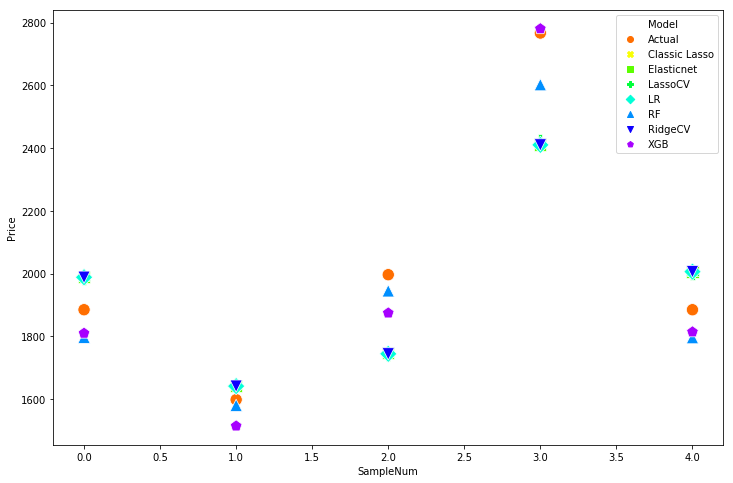

In [17]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.scatterplot(x = "SampleNum", y = "Price", data = results1, hue = results1.Model, ax = ax, style = "Model", s = 150, palette = "gist_rainbow")
plt.legend(loc = "best")
plt.ylim(min(results1.Price)-60, max(results1.Price)+60)
plt.show()

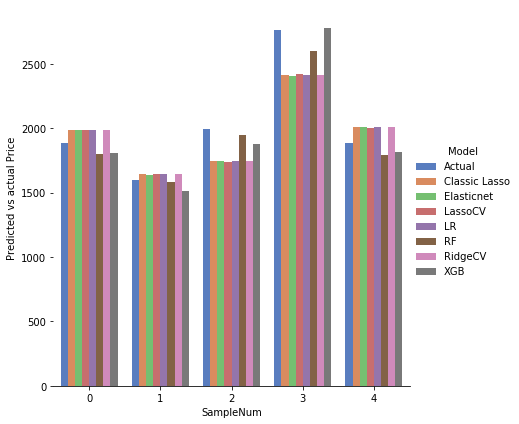

In [18]:
# fig, ax1 = plt.subplots(figsize = (12, 8))
g = sns.catplot(x = "SampleNum", y = "Price",hue = "Model",  data = results1, height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Predicted vs actual Price")